# Naive Bayes with categorical data

We previously learned how to use the Naive Bayes classifier on the Iris dataset, where each attribute had continuous values. Let us now try classifying a dataset with discrete attributes. For this task, we will use the Mushroom dataset, and build a classifier that tells us whether a given mushroom is edible or poisonous. To understand the dataset and its attributes, read the description at https://archive.ics.uci.edu/ml/datasets/Mushroom.


In [154]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')

In [185]:
data = pd.read_csv('agaricus-lepiota.data', sep=",", header=None)

# The first column of the dataset gives the label - poisonous or edible
X = data.values[:,1:]
y = data.values[:,0]
# Convert binary class labels ('p' and 'e') to integers (0 and 1)
y = (y == 'e').astype(int)

num_attributes = X.shape[1]

# Split train and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=5)
print(X_train.shape)
print(X_test.shape)

(5686, 22)
(2438, 22)


As we saw before, when the events model is discrete, we need to use the frequency of each feature and class to estimate the likelihood and probabilities.

For a given categorical feature, we count and find the frequency of each possible value of the feature in the given datapoint. For a text classification problem, this would correspond to a bag-of words approach. In this problem, since a given feature can only have one value, we can simply take a one-hot encoding of the feature. For example, take the *cap-surface* feature for a few datapoints,

| cap-surface |
| ----------- |
| f           |
| g           |
| y           |
| s           |
| y           |

On one-hot encoding, we would get the following.

| f    | g    | y    | s    |
| ---- | ---- | ---- | ---- |
| 1    | 0    | 0    | 0    |
| 0    | 1    | 0    | 0    |
| 0    | 0    | 1    | 0    |
| 0    | 0    | 0    | 1    |
| 0    | 0    | 1    | 0    |

This can be done for each individual feature. 

We know that the Naive Bayes model assumes the features are all conditionally independent of each other.

$$P(X_1,X_2,...X_n | C) = P(X_1|C)P(X_2|C)...P(X_n|C)$$

Therefore, we can simply fit a Multinomial distribution for each feature, encoded as given above, and then multiply the probabilities for all the features.

We will implement this in the function below. For each attribute, make _dummy variables_ by taking a one-hot encoding for each possible value of the attribute. You can do this with numpy directly, or use the MultiLabelBinarizer() function in scikit-learn. Compute the class-conditional probabilities for each attribute using Multinomial Naive Bayes, and then multiply the probabilities for all the classes.

In [186]:
def NaiveBayesCategorical(X_train, X_test, y_train):
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    probs = []
    for i in range(num_attributes):
        featureProbabilities = []
        for k,dataPoint in enumerate(X_test):
            featureValue = dataPoint[i]
            relevant = np.array((X_train[:,i] == featureValue).astype(int))
            featureProbabilities.append([(sum(relevant)- sum(relevant*y_train))/(len(y_train)-sum(y_train)),sum(relevant*y_train)/sum(y_train)])
        probs.append(featureProbabilities)
        print(i)
        
    featureProbabilities = []
   # for dataPoint in enumerate(X_test):
    #    featureProbabilities.append([(len(y_train) - sum(y_train))/len(y_train),sum(y_train)/len(y_train)])
    #probs.append(featureProbabilities)
    
    # Get final probability by multiplying probabilities of individual attributes (by the Naive Bayes assumption!)
    test_probs = np.prod(np.array(probs),axis=0)
    print(test_probs.shape)
    return test_probs

test_probs = NaiveBayesCategorical(X_train, X_test, y_train)
predictions = np.argmax(test_probs, axis=1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
(2438, 2)


## Evaluating a classifier

After performing classification, typically we would measure the prediction accuracy on the test set, that is, the percentage of data points correctly labeled by the classifier. It tells us how often our model is correct overall.

In [170]:
# Evaluate accuracy

acc = metrics.accuracy_score(y_test,predictions)
print(acc)


0.9971287940935193


In [118]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


There are other ways to evaluate the classifier that can shine light on the nature of its performance.

### Confusion Matrix

The confusion matrix gives us the following - 

**True Positives (TP)** - How many positive examples were classified correctly?

**True Negatives (TN)** - How many negative examples were classified correctly?

**False Positives (FP)** - How many negative examples were classified positive?

**False Negatives (FN)** - How many positive examples were classified negative?


|           .            | Predicted Negative(0) | Predicted Positive(1) |
|------------------------|-----------------------|-----------------------|
| **Actual Negative(0)** | true negative         | false positive        |
| **Actual Positive(1)** | false negative        | true positive         |


We can rewrite accuracy as the ratio of true positives and negatives to the total number of examples.

$$ Accuracy = \frac{TP + TN}{\text{total examples}} $$

### Precision

Precision tells us how often the model is correct when it predicts positive. It is useful when the costs of false positives are high. Think about a model that detects whether a patient has cancer. Would it be acceptable to falsely diagnose more patients with cancer?

$$ Precision = \frac{TP}{TP + FP} $$

### Recall

Recall tells us how often the model is correct when it predicts negative. It is useful when the costs of false negatives are high. Think about a model that detects whether a patient has a highly contagious disease. If the model let more infected patients pass with a positive diagnosis, we would be letting infected people out into the world to spread disease.

$$ Recall = \frac{TP}{TP + FN} $$

### F1 Score

This is the harmonic average of the precision and recall. An F1 score of 1 implies perfect precision and recall.

$$ F_1 = 2 \times \frac{precision \times recall}{precision + recall} $$

### Micro average

In the micro-average method, the true positives, false positives, and false negatives are summed up for all classes. The precision, recall and F1 can then be computed using these.

### Macro average

In the macro-average method, the true positives, false positives, and false negatives are summed up for each class separately. The precision, recall and F1 are computed for each class, and then averaged.

### Weighted average

This is a modification to the macro average method that takes class imbalance into account. As above, the precision, recall and F1 are computed for each class, but the average is weighted by the number of true instances per class.

### Support

This is the number of true instances for a given class.

In [128]:
# Print classification report

classification_report = metrics.classification_report(y_test,predictions)
print(classification_report)

              precision    recall  f1-score   support

           0       0.90      0.87      0.88        53
           1       0.82      0.87      0.85        38

   micro avg       0.87      0.87      0.87        91
   macro avg       0.86      0.87      0.87        91
weighted avg       0.87      0.87      0.87        91



Confusion matrix:
[[1204    2]
 [   5 1227]]


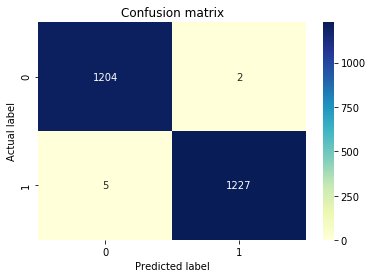

In [120]:
# Obtain the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test,predictions)
print("Confusion matrix:\n%s" % confusion_matrix)

# Prettier way to display the confusion matrix
import seaborn as sns
p = sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

The above scores were generated by helpful Python libraries. Let us generate the scores ourselves, using the formulae given earlier, and see if they match.

In [129]:
def compute_confusion_matrix(y_test, predictions):

    y_testCalc = y_test*3
    predictionsCalc = predictions*2
    sumCalc = y_testCalc + predictionsCalc
    truePositive = sum((sumCalc == 5).astype(int))
    trueNegitive = sum((sumCalc == 0).astype(int))
    falsePositive = sum((sumCalc == 2).astype(int))
    falseNegitive = sum((sumCalc == 3).astype(int))
    accuracy = (truePositive+trueNegitive)/len(sumCalc)
    precision = truePositive/ (truePositive+falsePositive)
    recall = truePositive/ (truePositive+falseNegitive)
    f1 = 2*(precision*recall)/(precision+recall)
    confusion_matrix = np.array([trueNegitive,falsePositive,falseNegitive,truePositive]).reshape(2,2)
    return accuracy, precision, recall, f1, confusion_matrix
    
accuracy, precision, recall, f1, confusion_matrix = compute_confusion_matrix(y_test, predictions)
print("Accuracy = %f" % accuracy)
print("Precision = %f" % precision)    
print("Recall = %f" % recall)    
print("F1 score = %f \n" % f1)
print("Confusion matrix:\n%s" % confusion_matrix)

Accuracy = 0.868132
Precision = 0.825000
Recall = 0.868421
F1 score = 0.846154 

Confusion matrix:
[[46  7]
 [ 5 33]]


In [122]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


# Naive Bayes with mixed data (discrete and continuous)

Now let's try using a dataset with both discrete and continuous attributes. For this task, we will use the Cleveland Heart Disease Dataset dataset from the UCI repository and perform binary classification. The classifier will tell us whether a given individual has heart disease or not. Before starting on this exercise, read the dataset description at https://archive.ics.uci.edu/ml/datasets/Heart+Disease and see the list of attributes. Identify which ones are discrete and which ones are continuous.

In [123]:
# Refer to the dataset description or the table below to verify this
categorical_indices = [1,2,5,6,8,10,11,12]
continuous_indices = [0,3,4,7,9] 

In [124]:
data_train = pd.read_csv('clevland.data', sep=",", header=None)

X = data_train.values[:,:-1]
y = data_train.values[:,-1]
y = (y > 0).astype(int)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=5)
print(X_train.shape)
print(X_test.shape)

data_train.head()

(212, 13)
(91, 13)


0    1    2      3      4    5    6      7    8    9    10   11   12  13
0  63.0  1.0  1.0  145.0  233.0  1.0  2.0  150.0  0.0  2.3  3.0  0.0  6.0   0
1  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0   2
2  67.0  1.0  4.0  120.0  229.0  0.0  2.0  129.0  1.0  2.6  2.0  2.0  7.0   1
3  37.0  1.0  3.0  130.0  250.0  0.0  0.0  187.0  0.0  3.5  3.0  0.0  3.0   0
4  41.0  0.0  2.0  130.0  204.0  0.0  2.0  172.0  0.0  1.4  1.0  0.0  3.0   0

The data contains both categorical as well as continuous (numerical) features. Fortunately, since we are following the Naive Bayes assumption, we can easily incorporate both types of features in our classifier, by multiplying all the probabilities for each individual feature.

For the categorical features, we follow the same method as before, by taking the one-hot encoding of each feature and fitting a Multinomial Naive Bayes model. The continuous features can be fit using Gaussian Naive Bayes.

In [157]:
import scipy.stats
import statistics 
def NaiveBayesMixed(X_train, X_test, y_train):

    probs = []   

    # Fit categorical attributes
    for i in categorical_indices:
        featureProbabilities = []
        for k,dataPoint in enumerate(X_test):
            featureValue = dataPoint[i]
            relevant = (X_train[:,i] == featureValue).astype(int)
            ydummy =filter(lambda a: a != '?', X_train)
            featureProbabilities.append([(sum(relevant)- sum(relevant*y_train))/(len(y_train)-sum(y_train)),sum(relevant*y_train)/sum(y_train)])
        probs.append(featureProbabilities)
    
    y_lessThan0 = np.ones((len(y_train),), dtype=int) - y_train[:]
    y_greaterThan0 = y_train[:]
    # Fit continuous attributes
    for i in continuous_indices:
        featureProbabilities = []
        for k,dataPoint in enumerate(X_test):
            relevant = X_train[:,i]
            lessThan0 = relevant * y_lessThan0
            greaterThan0 = relevant * y_greaterThan0
            lessThan0Mean = statistics.mean(lessThan0)
            lessThan0Var = statistics.variance(lessThan0)
            greaterThan0Mean =statistics.mean(greaterThan0)
            greaterThan0Var = statistics.variance(greaterThan0)            
            lessThan0Prob = scipy.stats.norm(lessThan0Mean,lessThan0Var).pdf(dataPoint[i])
            greaterThan0Prob = scipy.stats.norm(greaterThan0Mean,greaterThan0Var).pdf(dataPoint[i])
            featureProbabilities.append([lessThan0Prob,greaterThan0Prob])
        probs.append(featureProbabilities)

    featureProbabilities = []
    for dataPoint in enumerate(X_test):
        featureProbabilities.append([(len(y_train) - sum(y_train))/len(y_train),sum(y_train)/len(y_train)])
    probs.append(featureProbabilities)
# Get final probability by multiplying probabilities of individual classifiers (by the Naive Bayes assumption!)
    test_probs = np.prod(np.array(probs),axis=0)
    return test_probs

test_probs = NaiveBayesMixed(X_train, X_test, y_train)
predictions = np.argmax(test_probs, axis=1)

KeyboardInterrupt: 

In [136]:
accuracy, precision, recall, f1, confusion_matrix = compute_confusion_matrix(y_test, predictions)
print("Accuracy = %f" % accuracy)
print("Precision = %f" % precision)    
print("Recall = %f" % recall)    
print("F1 score = %f \n" % f1)
print("Confusion matrix:\n%s" % confusion_matrix)

Accuracy = 0.868132
Precision = 0.825000
Recall = 0.868421
F1 score = 0.846154 

Confusion matrix:
[[46  7]
 [ 5 33]]


In [127]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#
